# Cō Vidis?

**Cō Vidis?** [kʷoː ˈwɪːdɪs] ➡️ latin for "COVID-19, where are you going?"<br/>
(https://en.wikipedia.org/wiki/Quo_vadis)

A Dashboard to follow the state of the Coronavirus with a focus on Switzerland 🇨🇭.

The data source is checked at 6:00, 12:00 and 18:00 GMT+1 (Swiss time).

- **Author** : Fred Montet (https://twitter.com/fredmontet)
- **Repository** : https://github.com/fredmontet/co-vidis
- **Data Source** : https://github.com/CSSEGISandData/COVID-19

---


## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set(style="whitegrid")
%config InlineBackend.figure_format ='retina'

# The command to generate the HTML
# jupyter nbconvert covid-19.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --TagRemovePreprocessor.remove_input_tags='{"remove_input"}'

## Functions

In [2]:
def create_by_country_dataframe(df):
    by_country = df.T
    by_country.columns = by_country.loc["Country/Region"]
    by_country = by_country[4:]
    by_country = by_country.groupby(axis=1, by=by_country.columns).sum()
    by_country.index = pd.to_datetime(by_country.index)
    return by_country

def is_it_spreading(df):
    return df.diff()

## Data Loading

In [3]:
data = "../data/raw/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/"

In [4]:
confirmed = f"{data}time_series_19-covid-Confirmed.csv"
deaths = f"{data}time_series_19-covid-Deaths.csv"
recovered = f"{data}time_series_19-covid-Recovered.csv"

In [5]:
df_confirmed = pd.read_csv(confirmed)
df_deaths = pd.read_csv(deaths)
df_recovered = pd.read_csv(recovered)

In [6]:
df = {
    "confirmed": df_confirmed,
    "deaths": df_deaths,
    "recovered": df_recovered
}

## Compute a Index by Country

In [7]:
by_country = {
    "confirmed" : create_by_country_dataframe(df.get("confirmed")),
    "deaths" : create_by_country_dataframe(df.get("deaths")),
    "recovered" : create_by_country_dataframe(df.get("recovered"))
}

Compute the existing cases and add them to the Dictionnary

In [8]:
# Active cases = total confirmed - total recovered - total deaths
by_country["existing"] = by_country["confirmed"] - by_country["recovered"] - by_country["deaths"]

## Regions of Interest

In [9]:
CH = ["Switzerland"]
CH_neighbors = ["Italy", "France", "Liechtenstein", "Austria", "Germany"]
CH_neighbors_no_italy = ["France", "Liechtenstein", "Austria", "Germany"]

# Bulgaria, Cyprus and Romania are not in the list
# Switzerland has been added
EU = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]
EU_no_italy = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]

## Period of Interest

In [10]:
last_n_days = 14

In [11]:
existing = by_country.get("existing")[-last_n_days:]
confirmed = by_country.get("confirmed")[-last_n_days:]
deaths = by_country.get("deaths")[-last_n_days:]
recovered = by_country.get("recovered")[-last_n_days:]

## Switzerland

In [12]:
# Linear Regression
df = existing[CH].diff()[1:]
X = df.index.factorize()[0].reshape(-1,1)
Y = df.values
m = LinearRegression().fit(X, Y)
Y_pred = m.predict(X)
Y_pred = pd.DataFrame(Y_pred)
Y_pred.index = df.index
Y_pred = Y_pred.rename(columns={0:"Trend"})

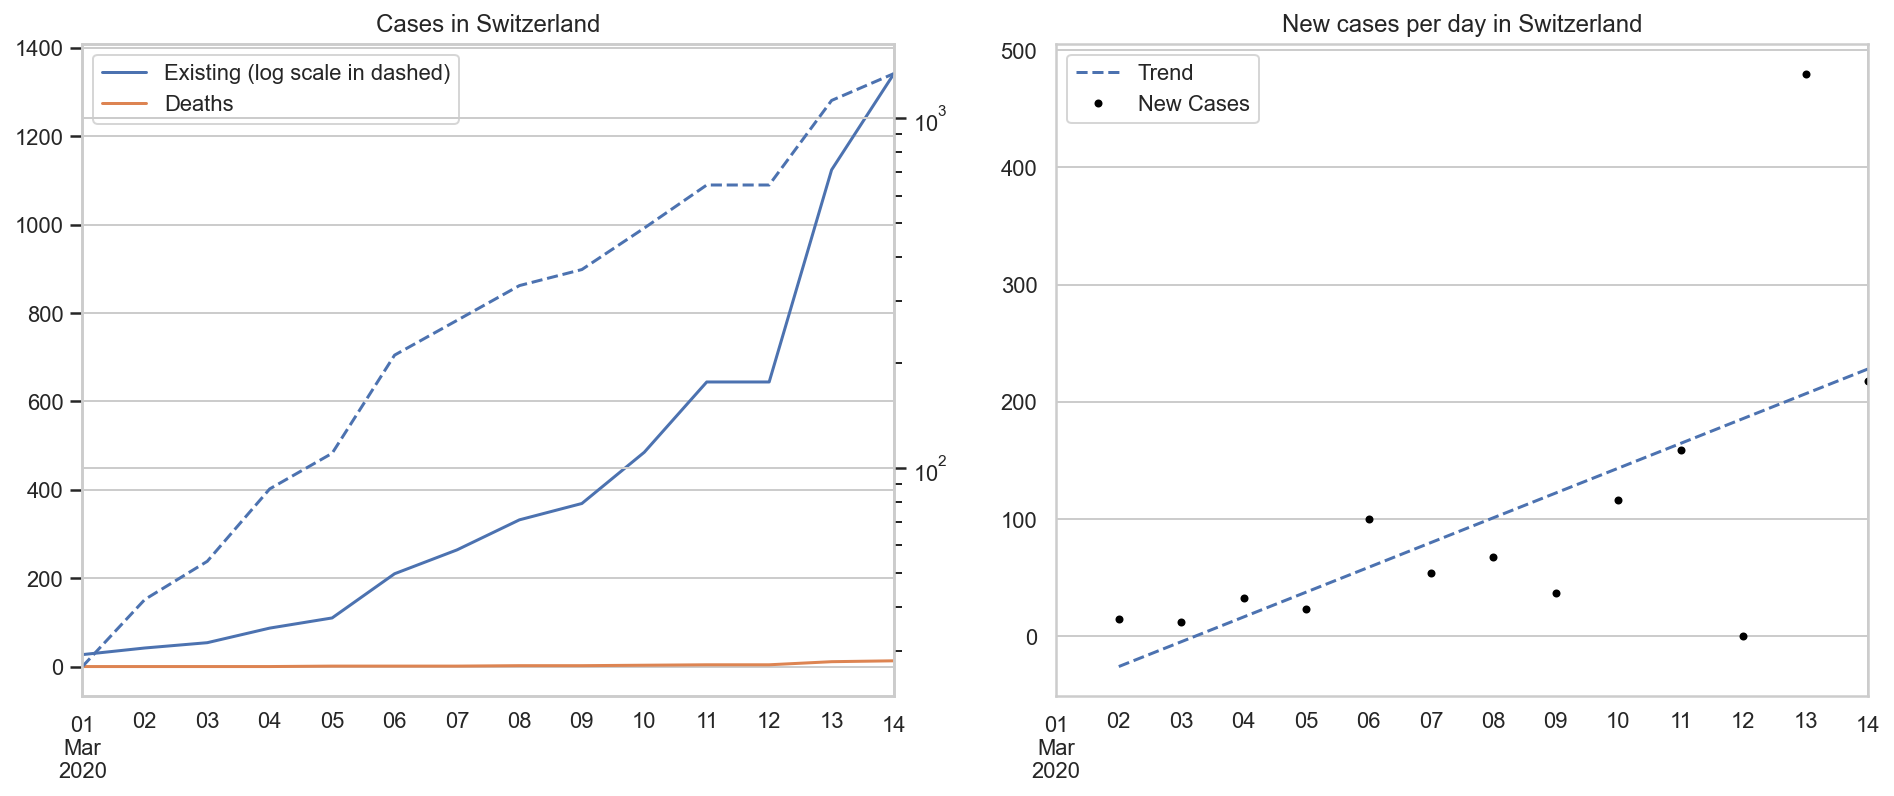

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
    
ax1 = existing[CH].sum(axis=1).plot(ax=ax1, title="Cases in Switzerland")
ax1 = deaths[CH].sum(axis=1).plot(ax=ax1)
ax1log = ax1.twinx()
ax1log = existing[CH].sum(axis=1).plot(ax=ax1log, logy=True, style="--")

Y_pred.plot(ax=ax2, figsize=(16,6), style="--", title="New cases per day in Switzerland");
existing[CH].diff().plot(ax=ax2, style=".", color="black", title="New cases per day in Switzerland");

ax1.legend(["Existing (log scale in dashed)", "Deaths"]);
ax2.legend(["Trend", "New Cases"]);

## Rate

In [88]:

df = confirmed[CH].reset_index()

In [89]:
arr = []
arr.append(None)
for i, r in df.iterrows():
    if i < df.index[-1]:
        t0 = df.iloc[i]["Switzerland"]
        t1 = df.iloc[i+1]["Switzerland"]
        arr.append(t1/t0)

In [90]:
arr

[None,
 1.5555555555555556,
 1.3333333333333333,
 1.6071428571428572,
 1.2666666666666666,
 1.8771929824561404,
 1.2523364485981308,
 1.257462686567164,
 1.1097922848664687,
 1.3128342245989304,
 1.3279022403258656,
 1.0,
 1.7469325153374233,
 1.1931518876207199]

In [91]:
df["rate"] = arr

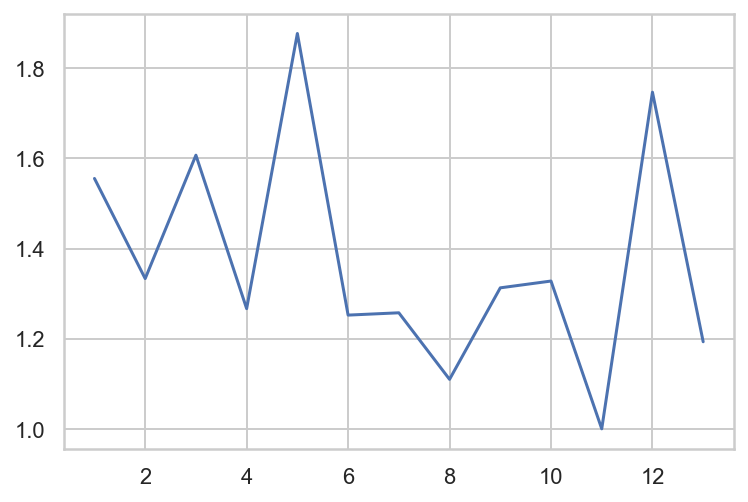

In [95]:
df["rate"].plot(style="-");

## Growth Factor

In [158]:
def growth_factor(df, column):
    df = df.diff().reset_index()
    arr = []
    arr.append(None)
    for i, r in df.iterrows():
        if i < df.index[-1]:
            delta_N_d0 = df.iloc[i][column]
            delta_N_d1 = df.iloc[i+1][column]
            arr.append(delta_N_d1/delta_N_d0)
    growth = pd.DataFrame(arr, index=df["index"], columns=["Growth"])
    growth = growth.rename(index={"index":"timestamp"})
    return growth

In [164]:
world = pd.DataFrame(by_country.get("existing").sum(axis=1), columns=["World"])

In [165]:
df = growth_factor(world, "World")

In [186]:
from sklearn.linear_model import LinearRegression

In [191]:
df[2:]

,Growth
index,
2020-01-24,2.884211
2020-01-25,1.729927
2020-01-26,1.386076
2020-01-27,1.178082
2020-01-28,3.302326
2020-01-29,0.221831
2020-01-30,3.550265
2020-01-31,0.780924
2020-02-01,1.274173


In [192]:
df = df[2:]
X = df.index.factorize()[0].reshape(-1,1)
Y = df.values
m = LinearRegression().fit(X, Y)
Y_pred = m.predict(X)
Y_pred = pd.DataFrame(Y_pred)
Y_pred.index = df.index
Y_pred = Y_pred.rename(columns={0:"Trend"})

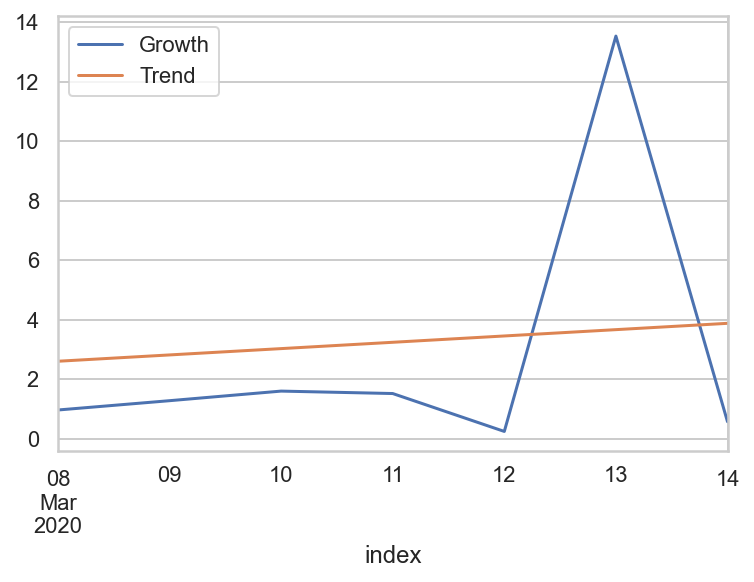

In [201]:
fig, ax = plt.subplots()

df[-7:].plot(ax=ax)
Y_pred[-7:].plot(ax=ax)

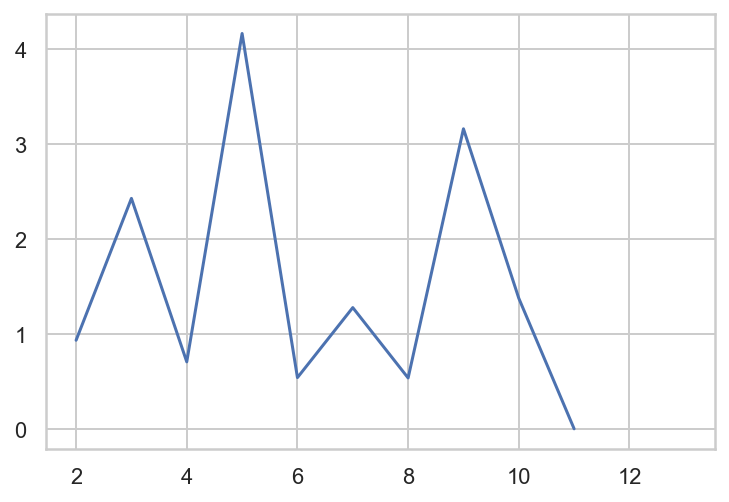

In [117]:
df["gf"].plot()

---

In [17]:
print(f"last available data : {by_country['existing'].iloc[-1].name.date()}")

last available data : 2020-03-14
